In [133]:
import os
import pathlib
import random
import shutil
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import scipy.stats
from sklearn import metrics, preprocessing
import pandas as pd
from keras.utils import audio_dataset_from_directory
from scipy.io import wavfile
from IPython import display

from imblearn.over_sampling import RandomOverSampler

# Define the path to the dataset directory
DATASET_PATH = "C:/Users/ITPKL/Desktop/pydev/ccw_sound"
data_dir = pathlib.Path(DATASET_PATH)

# Create training and validation dataset
train_ds, val_ds =  audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

# Retrieve the class names from the training dataset
label_names = np.array(train_ds.class_names)
label_names_val = np.array(val_ds.class_names)


# Print the label names
print()
print("label names training:", label_names)
print("label names testing:", label_names_val)



# # Define the path to the dataset directory
# DATASET_PATH = "C:/Users/ITPKL/Desktop/pydev/ccw_sound"
# val_path = "C:/Users/ITPKL/Desktop/pydev/testing_model"

# data_dir_train = pathlib.Path(DATASET_PATH)
# data_dir_val = pathlib.Path(val_path)

# # Create training and validation dataset
# train_ds =  audio_dataset_from_directory(
#     directory=data_dir_train,
#     batch_size=64,
#     # validation_split=0.2,
#     seed=0,
#     output_sequence_length=16000,
#     subset='both'
# )

# # Create training and validation dataset
# val_ds =  audio_dataset_from_directory(
#     directory=data_dir_val,
#     batch_size=64,
#     seed=0,
#     output_sequence_length=16000,
#     subset='both'
# )

# # Retrieve the class names from the training dataset
# label_names = np.array(train_ds.class_names)
# label_names_val = np.array(val_ds.class_names)

# # Print the label names
# print()
# print("label names training:", label_names)
# print("label names val:", label_names_val)



Found 473 files belonging to 2 classes.
Using 332 files for training.
Using 141 files for validation.

label names training: ['NG' 'OK']
label names testing: ['NG' 'OK']


In [134]:
# Define a function to remove singleton dimensions from audio tensor
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# Apply the squeeze function to the training and validation datasets
# train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
# val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# print(train_ds)


# Define the fixed length for FFTs
fft_length = 1024

# Initialize lists to store magnitude of FFTs, corresponding labels, and mask
fft_magnitude_data = []
labels = []
masks = []

# fft_magnitude_val = []
# labels_val = []
# masks_val = []

# Define a function to read WAV files and convert to FFT
def read_wav_file(file_path):
    try:
        sample_rate, audio = wavfile.read(file_path)
        if len(audio) == 0:
            return None
        return np.fft.fft(audio)[:fft_length]
    except Exception as e:
        print(f"Error reading WAV file: {file_path}")
        print(f"Error message: {str(e)}")
        return None



In [135]:
# Loop through the dataset directory and process each WAV file
# for label_idx, label in enumerate(label_names):
#     label_dir = data_dir / label
#     wav_files = list(label_dir.glob('*.wav'))
#     for wav_file in wav_files:
#         # Read and compute FFT for each WAV file
#         fft = read_wav_file(wav_file)
#         if fft is not None:
#             fft_magnitude = np.abs(fft)
#             mask = np.ones_like(fft_magnitude)
#             mask[len(fft_magnitude):] = 0
#             fft_magnitude_padded = np.pad(fft_magnitude, (0, fft_length - len(fft_magnitude)))
#             mask_padded = np.pad(mask, (0, fft_length - len(fft_magnitude)))
#             fft_magnitude_data.append(np.zeros((fft_length,)))  # Create an array of zeros with the desired shape
#             fft_magnitude_data[-1][:len(fft_magnitude_padded)] = np.resize(fft_magnitude_padded, (1024,))

#             masks.append(mask_padded)
#             labels.append(label_idx)
#             print(fft_magnitude_padded.shape)

# Loop through the dataset directory and process each WAV file
for label_idx, label in enumerate(label_names):
    label_dir = data_dir / label
    wav_files = list(label_dir.glob('*.wav'))
    for wav_file in wav_files:
        # Read and compute FFT for each WAV file
        fft = read_wav_file(wav_file)
        if fft is not None:
            fft_magnitude = np.abs(fft)
            mask = np.ones_like(fft_magnitude)
            mask[len(fft_magnitude):] = 0
            fft_magnitude_padded = np.pad(fft_magnitude, (0, fft_length - len(fft_magnitude)))
            mask_padded = np.pad(mask, (0, fft_length - len(mask)))
            
            # Append the padded FFT magnitude and mask to their respective lists
            fft_magnitude_data.append(fft_magnitude_padded)
            masks.append(mask_padded)
            labels.append(label_idx)
# fft_magnitude_val = []
# labels_val = []
# masks_val = []


# for label_idx, label in enumerate(label_names_val):
#     label_dir = data_dir_val / label
#     wav_files = list(label_dir.glob('*.wav'))
#     for wav_file in wav_files:
#         # Read and compute FFT for each WAV file
#         fft = read_wav_file(wav_file)
#         if fft is not None:
#             fft_magnitude = np.abs(fft)
#             mask = np.ones_like(fft_magnitude)
#             mask[len(fft_magnitude):] = 0
#             fft_magnitude_padded = np.pad(fft_magnitude, (0, fft_length - len(fft_magnitude)))
#             mask_padded = np.pad(mask, (0, fft_length - len(mask)))
            
#             # Append the padded FFT magnitude and mask to their respective lists
#             fft_magnitude_val.append(fft_magnitude_padded)
#             masks_val.append(mask_padded)
#             labels_val.append(label_idx)

# Convert lists to numpy arrays
# fft_magnitude_data = np.array(fft_magnitude_data)
# labels = np.array(labels)
# masks = np.array(masks)



In [136]:
# Initialize an empty list to store the padded masks
# padded_masks_list = []
# max_length = max(len(mask) for mask in masks)
# # Loop through the masks list and pad each mask to the desired shape
# for mask in masks:
#     padded_mask = np.pad(mask, (0, fft_length - len(mask)))
#     padded_masks_list.append(padded_mask)
# padded_masks_list = [np.pad(mask, (0, max_length - len(mask))) for mask in padded_masks_list]
# # Convert the list to a numpy array
# padded_masks = np.array(padded_masks_list)
# # Convert the lists to numpy arrays
# fft_magnitude_data = np.array(fft_magnitude_data)
# padded_masks = np.array(padded_masks)
# labels = np.array(labels)

#=================================

# Initialize an empty list to store the padded masks
padded_masks = [np.pad(mask, (0, fft_length - len(mask))) for mask in masks]

# Find the maximum length among all padded masks
max_length = max(len(mask) for mask in padded_masks)

# Pad each mask to the maximum length
padded_masks = [np.pad(mask, (0, max_length - len(mask))) for mask in padded_masks]

# Convert the lists to numpy arrays
fft_magnitude_data = np.array(fft_magnitude_data)
padded_masks = np.array(padded_masks)
labels = np.array(labels)


# Print the shapes of the resulting arrays
print("FFT Magnitude Data Shape:", fft_magnitude_data.shape)
print("Masks Shape:", padded_masks.shape)
print("Labels Shape:", labels.shape)
#=================================
# Find the maximum length of the masks
# max_length = max(len(mask) for mask in masks)

# # Loop through the masks list and pad each mask to the maximum length

# for mask in masks:
#     print(f"Original mask shape: {mask.shape}")
#     if len(mask) < max_length:
#         padded_mask = np.pad(mask, (0, max_length - len(mask)))
#     else:
#         padded_mask = mask
#     print(f"Padded mask shape: {padded_mask.shape}")
#     if padded_mask.shape != (1024,):
#         print(f"Warning: Found a padded_mask with shape {padded_mask.shape}")
#         padded_masks_list.append(padded_mask)


FFT Magnitude Data Shape: (473, 1024)
Masks Shape: (473, 1024)
Labels Shape: (473,)


In [137]:


# Perform oversampling using RandomOverSampler
# oversampler = RandomOverSampler()
# fft_magnitude_data_resampled, labels_resampled = oversampler.fit_resample(fft_magnitude_data, labels)


# Create a DataFrame with the magnitude of the FFT outputs and numerical labels
fft_magnitude_df = pd.DataFrame(fft_magnitude_data)

# Rename the columns of the DataFrame to fft1, fft2, ...
new_columns = [f'fft{n}' for n in range(1, fft_length + 1)]
fft_magnitude_df.columns = new_columns

# Add a new column 'Label' to the DataFrame based on the folder name
fft_magnitude_df['label'] = labels

# Display the DataFrame
display.display(fft_magnitude_df)

,fft1,fft2,fft3,fft4,fft5,fft6,fft7,fft8,fft9,fft10,...,fft1016,fft1017,fft1018,fft1019,fft1020,fft1021,fft1022,fft1023,fft1024,label
0,1416527.0,1.534913e+06,1.481020e+06,1.336521e+06,1.157097e+06,1.008574e+06,8.930119e+05,1.026871e+06,1.196654e+06,770510.843897,...,118066.772984,87248.485395,92733.535042,88922.450524,10733.267770,15231.329464,91575.166441,29807.025489,55327.762468,0
1,1426742.0,1.659645e+06,1.602556e+06,1.514963e+06,1.411796e+06,1.316387e+06,1.158554e+06,1.070180e+06,1.044197e+06,908234.359463,...,137270.595254,117181.042521,30885.851085,14889.204724,142629.610215,35176.646444,86411.346576,36997.923303,29933.330010,0
2,1344298.0,1.407623e+06,1.270970e+06,1.128814e+06,1.009130e+06,9.343982e+05,8.340298e+05,7.711179e+05,6.591696e+05,600910.735109,...,57002.256745,115287.129791,41399.824557,67447.087992,5025.758244,137980.314361,66025.181534,48237.035251,16610.678151,0
3,1740862.0,1.879003e+06,1.725475e+06,1.623986e+06,1.506314e+06,1.251800e+06,1.268010e+06,9.034669e+05,1.062912e+06,793445.997593,...,79891.377669,18408.540609,24268.616826,50915.270163,48772.634306,15945.381320,43109.599653,13862.516264,42463.990027,0
4,1181819.0,1.793137e+05,5.736580e+05,1.531910e+06,6.349015e+05,4.290935e+05,3.545699e+05,2.977726e+05,4.025568e+04,736870.815090,...,2883.175062,1246.691866,1856.459674,4308.026472,215.558581,1906.721542,2094.540333,537.606945,2068.517589,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,15959.0,1.948426e+04,2.014058e+04,1.186024e+04,8.784586e+03,1.715438e+03,1.895906e+03,2.794564e+03,2.022552e+03,2520.883198,...,130.918256,272.850365,313.552199,388.058946,307.827716,345.005441,130.197232,494.148891,198.964446,1
469,25284.0,2.224084e+04,6.793085e+03,8.709325e+03,3.426741e+03,1.281528e+03,1.279535e+03,2.717508e+03,4.964572e+03,944.189046,...,62.114873,184.735370,175.347540,50.440945,122.805403,134.647616,215.175542,82.733292,238.259737,1
470,3340.0,1.585135e+04,1.620679e+03,4.511305e+03,2.684435e+03,1.145790e+03,2.954404e+03,1.362180e+03,2.176751e+03,730.094788,...,186.238336,146.131469,142.753055,441.302084,324.306379,389.078267,245.355023,96.238619,181.092827,1
471,5535.0,1.943113e+04,1.980064e+04,6.432451e+03,4.024571e+03,2.915150e+03,2.474908e+03,1.587648e+03,2.096610e+03,1708.986146,...,404.404024,325.398951,228.581103,44.146051,94.319274,304.719047,204.485256,256.157029,125.186111,1


In [138]:
# Filter the DataFrame to only rows where 'label' is 0 or 1
filtered_df = fft_magnitude_df[fft_magnitude_df['label'].isin([0, 1])]

# Sample random rows from the filtered DataFrame
random_rows = filtered_df.sample(n=10, random_state=1)

# Assign the sampled rows to a new variable
new_variable = random_rows

# Remove the sampled rows from the original DataFrame
fft_magnitude_df = fft_magnitude_df.drop(random_rows.index)

In [139]:
display.display(new_variable)

,fft1,fft2,fft3,fft4,fft5,fft6,fft7,fft8,fft9,fft10,...,fft1016,fft1017,fft1018,fft1019,fft1020,fft1021,fft1022,fft1023,fft1024,label
179,2183.0,7.038706e+03,5.413469e+03,6.936925e+03,2.495625e+03,5.364478e+03,3.881053e+03,2.753388e+03,3681.765054,4858.732113,...,235.615783,151.873828,239.519863,213.625305,81.409904,168.612281,130.993672,213.344891,212.109801,1
298,10658.0,2.483334e+04,4.053783e+03,1.416841e+04,6.721790e+03,2.711543e+03,6.118729e+03,5.523757e+03,5248.115809,4096.556973,...,185.985200,237.848119,173.474365,411.217645,21.122983,370.686671,542.135090,210.293114,829.476043,1
31,1697689.0,1.799409e+06,1.660272e+06,1.528585e+06,1.406726e+06,1.305143e+06,1.095934e+06,1.040777e+06,787688.863545,768307.000363,...,73851.374092,61463.215955,18680.162343,37851.978364,93489.861284,47503.034548,65608.710420,10029.393535,13902.966283,0
453,6051.0,1.129757e+04,8.096071e+03,3.229567e+03,4.762063e+03,3.447625e+03,2.584719e+03,2.975939e+03,1005.311647,1689.292888,...,183.806076,159.461067,170.886581,98.926856,308.133106,147.063735,328.907314,131.889464,120.200971,1
247,4300.0,1.362044e+04,8.616364e+03,7.073891e+03,1.111709e+03,2.720775e+02,4.261100e+03,2.316912e+03,1327.093188,2186.564038,...,270.941990,303.251641,312.519250,112.358570,237.068579,100.967945,384.684134,353.251296,346.087144,1
245,146.0,6.806360e+03,1.039267e+04,6.741826e+03,7.331742e+03,3.025204e+03,5.162916e+03,4.291454e+03,4695.124361,1796.927714,...,25.313834,49.520334,705.221337,930.791589,1568.411164,1902.838551,349.547093,649.994637,394.978244,1
172,5943.0,5.468056e+03,4.618833e+03,3.169876e+03,2.771433e+03,2.339887e+03,2.019981e+03,1.240795e+03,1332.739156,711.511569,...,186.792148,331.427993,57.602817,130.464890,132.981750,210.666254,49.475962,51.171858,245.891260,1
295,8254.0,5.783661e+03,1.178146e+04,3.033003e+03,3.726269e+03,1.318811e+03,3.754795e+03,2.003880e+03,5121.610052,2235.951763,...,265.196732,180.093315,119.485739,224.372893,195.840954,330.320256,126.371882,116.045068,89.358145,1
139,16765.0,1.814337e+04,1.038916e+04,3.088872e+03,3.503278e+03,6.995138e+03,1.523810e+03,5.041753e+03,2782.893788,2513.262396,...,342.386750,116.254538,150.151807,238.055270,250.333549,441.254652,246.503605,297.653900,90.738690,1
159,14908.0,3.903977e+04,1.854839e+04,3.497013e+03,4.962964e+03,3.199326e+03,1.020966e+04,2.623349e+03,2988.815508,1716.104357,...,393.272581,825.423498,136.778821,334.371716,171.798796,223.642131,148.740727,249.662097,245.778051,1


In [140]:
# Convert the DataFrame to a list of tuples
fft_magnitude_tuples = [tuple(row) for row in fft_magnitude_df.values]
fft_magnitude_test = [tuple(row) for row in new_variable.values]

# Shuffle the list of tuples
random.shuffle(fft_magnitude_tuples)
random.shuffle(fft_magnitude_test)

# Display the shuffled list of tuples
# for tup in fft_magnitude_tuples:
#     print(tup)

In [141]:
# Takes all fft values as X and drops the Label
X = fft_magnitude_df.drop(['label'], axis=1)
y = fft_magnitude_df['label']


Xcoba = new_variable.drop(['label'], axis=1)
Ycoba  = new_variable['label']  

print (y)
print (X)


0      0
1      0
2      0
3      0
4      0
      ..
468    1
469    1
470    1
471    1
472    1
Name: label, Length: 463, dtype: int32
          fft1          fft2          fft3          fft4          fft5  \
0    1416527.0  1.534913e+06  1.481020e+06  1.336521e+06  1.157097e+06   
1    1426742.0  1.659645e+06  1.602556e+06  1.514963e+06  1.411796e+06   
2    1344298.0  1.407623e+06  1.270970e+06  1.128814e+06  1.009130e+06   
3    1740862.0  1.879003e+06  1.725475e+06  1.623986e+06  1.506314e+06   
4    1181819.0  1.793137e+05  5.736580e+05  1.531910e+06  6.349015e+05   
..         ...           ...           ...           ...           ...   
468    15959.0  1.948426e+04  2.014058e+04  1.186024e+04  8.784586e+03   
469    25284.0  2.224084e+04  6.793085e+03  8.709325e+03  3.426741e+03   
470     3340.0  1.585135e+04  1.620679e+03  4.511305e+03  2.684435e+03   
471     5535.0  1.943113e+04  1.980064e+04  6.432451e+03  4.024571e+03   
472     8388.0  2.126977e+04  1.877757e+04  4.06

In [142]:

# Splits the datasset into 80% training set and 20% test set
from sklearn.model_selection import train_test_split
# Splits the dataset into 80% training set and 20% test set
X_train, X_coba, y_train, y_coba = train_test_split(X, y, test_size=0.2, random_state=0)

# Perform oversampling using RandomOverSampler
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# # Create a DataFrame with the magnitude of the FFT outputs and numerical labels
# X_train = pd.DataFrame(X_train_resampled, columns=new_columns)
# y_train['label'] = y_train_resampled

# Display the DataFrame
display.display(X_train_resampled)
display.display(y_train_resampled)


print ("Shape of X_train :", X_train.shape)
print ("Shape of y_train :", y_train.shape)
print ("Shape of X_coba :", X_coba.shape)
print ("Shape of y_test :", y_coba.shape)



# Rest of the code...




,fft1,fft2,fft3,fft4,fft5,fft6,fft7,fft8,fft9,fft10,...,fft1015,fft1016,fft1017,fft1018,fft1019,fft1020,fft1021,fft1022,fft1023,fft1024
0,3279.0,9.708115e+03,8.898832e+03,1.058911e+04,6.025332e+03,5668.884498,2303.431198,2.887553e+03,1477.523484,732.038382,...,383.297540,417.821789,496.461795,326.263581,405.482663,437.853406,263.936265,240.542899,274.442384,577.603321
1,230.0,7.104238e+03,5.157001e+03,1.840072e+03,1.357486e+03,5793.556335,2336.535389,1.706568e+03,2744.153165,1403.122493,...,226.002379,273.014598,237.082495,78.204060,187.842706,48.848652,12.120157,214.554371,256.157005,241.479292
2,12429.0,8.303786e+03,1.761597e+03,3.688512e+03,3.845782e+03,4923.998428,4790.375387,4.565869e+03,1920.380475,3937.717309,...,212.060201,85.544857,131.968575,192.141297,345.037510,77.861282,160.702104,356.564305,137.524638,140.159728
3,10504.0,1.170034e+04,4.698541e+03,4.748022e+03,4.159572e+03,2107.697496,2895.319503,3.730284e+03,2665.068137,1909.620515,...,461.076012,267.407978,162.022094,184.464909,209.796341,107.945184,171.500418,81.352314,228.429064,474.398811
4,7976.0,1.108295e+04,3.495698e+03,4.634225e+03,1.797980e+03,1687.443892,6359.820677,1.429345e+03,3130.033818,102.247759,...,86.352782,141.389232,125.062388,50.262753,178.785239,196.652610,110.280235,297.780716,168.822271,126.118992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,1344298.0,1.407623e+06,1.270970e+06,1.128814e+06,1.009130e+06,934398.199258,834029.770289,7.711179e+05,659169.574308,600910.735109,...,56332.070204,57002.256745,115287.129791,41399.824557,67447.087992,5025.758244,137980.314361,66025.181534,48237.035251,16610.678151
650,6973.0,2.804894e+04,4.174405e+03,1.728656e+04,7.742420e+02,16771.013116,5230.468737,2.278654e+02,2351.507504,2720.875210,...,2891.217391,2275.379917,2274.878545,2475.438684,2560.155715,2042.666172,2004.373313,2164.131463,2003.069021,2800.268801
651,27901.0,2.654355e+05,1.036540e+05,3.536084e+05,4.188071e+05,308935.266010,652278.927698,1.120894e+06,985762.254339,789497.036765,...,109111.354526,157303.926515,44862.978931,130817.611148,49156.354992,64843.953303,65495.918892,67464.725024,76535.463984,122258.568441
652,1181819.0,1.793137e+05,5.736580e+05,1.531910e+06,6.349015e+05,429093.545401,354569.918340,2.977726e+05,40255.677587,736870.815090,...,3089.853727,2883.175062,1246.691866,1856.459674,4308.026472,215.558581,1906.721542,2094.540333,537.606945,2068.517589


0      1
1      1
2      1
3      1
4      1
      ..
649    0
650    0
651    0
652    0
653    0
Name: label, Length: 654, dtype: int32

Shape of X_train : (370, 1024)
Shape of y_train : (370,)
Shape of X_coba : (93, 1024)
Shape of y_test : (93,)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        86

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



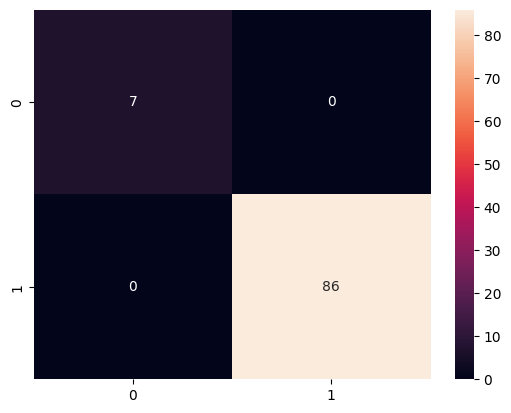

In [146]:
# Perform feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_coba = sc_X.transform(X_coba)

# Train the SVM (Support Vector Machine) classifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
classifier = SVC(kernel='rbf',gamma="scale", C=2.0)
classifier.fit(X_train, y_train)

# Evaluate the trained model on the test data
y_predict = classifier.predict(X_coba)

# Compute the confusion matrix to evaluate prediction accuracy
cm = confusion_matrix(y_coba, y_predict)

# Create a heatmap of the confusion matrix with annotations
sns.heatmap(cm, annot=True)

# Display a classification report
print(classification_report(y_coba,y_predict,zero_division=1))

fft_magnitude_df.to_csv('fft_magnitude_data.csv', index=False)

In [147]:



# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(Xtes, yTes, test_size=0.2, random_state=42)

# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix
# classifier = SVC(kernel='rbf',gamma="scale", C=2.0)
# classifier.fit(X_train, y_train)

# # Evaluate the trained model on the test data
# y_predict = classifier.predict(X_coba)
# # Print the shapes of the training, validation, and test sets
# print("Shape of X_train:", X_train.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of X_val:", X_val.shape)
# print("Shape of y_val:", y_val.shape)
# print("Shape of X_coba:", X_coba.shape)
# print("Shape of y_test:", y_test.shape)


# from sklearn.metrics import accuracy_score

# # Prediksi label menggunakan model Anda
# y_pred = model.predict(X_val)

# # Menghitung akurasi dari set validasi
# accuracy = accuracy_score(y_val, y_pred)

# # Menampilkan akurasi
# print("Akurasi dari set validasi:", accuracy)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_coba, y_predict)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [145]:
##########################
# SAVE-LOAD using joblib #
##########################
import joblib

# save the trained model into a pickle file (.pkl) 
joblib.dump(classifier, "model2024-01-30.pkl") 


['model2024-01-30.pkl']